# Clustering Jarndyce

In [1]:
import codecs
import json
import os
import string
from collections import Counter, defaultdict
from glob import glob
from pathlib import Path

import numpy as np
from tqdm import tqdm

In [2]:
glob("E:/Jarndyce/Jarndyce/plain_full_clean/*.txt")[0]

'E:/Jarndyce/Jarndyce/plain_full_clean\\36105213320000.txt'

In [3]:
corpus = []
labels = []
for text in glob("E:/Jarndyce/Jarndyce/plain_full_clean/*.txt"):
    with codecs.open(text, "r", "utf8") as file:
        corpus.append(file.read())
        labels.append(file.name)

In [4]:
corpus[0][:250]

'front and her favourites one year or story of three homes by author of of the south of life has not one link to cast with original illustrations and covent garden scribner welford and co chapter ii chapter iii on the quai chapter iv quarrel and its r'

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

In [6]:
n_features = 300
use_hashing = False
use_idf = True

if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(corpus).toarray()

In [7]:
X.shape

(1417, 300)

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

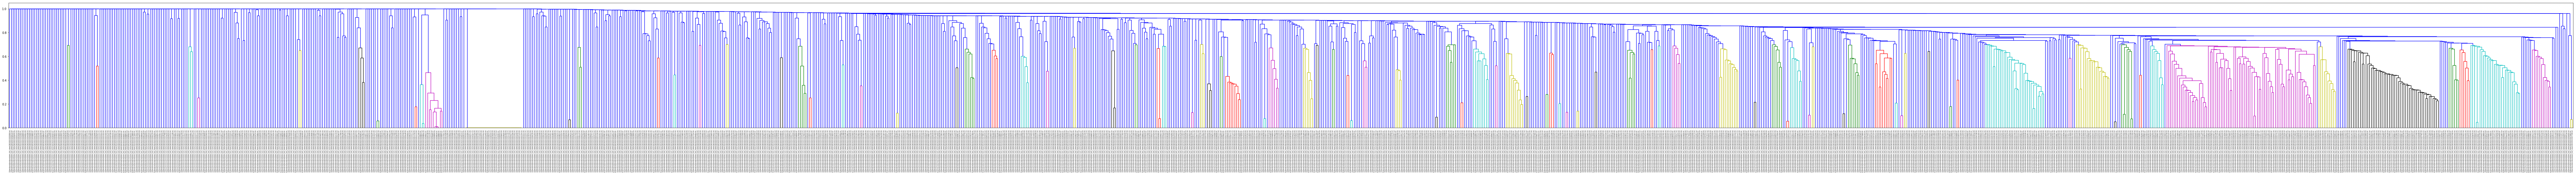

In [9]:
plt.figure(figsize=(160, 8))  
dendrogram(
    linkage(X, 'single'), 
    labels=labels,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
);

We could draw a line to roughly cross over 50 clusters.

In [10]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X) 

array([20, 31,  4, ...,  4, 13,  4], dtype=int64)

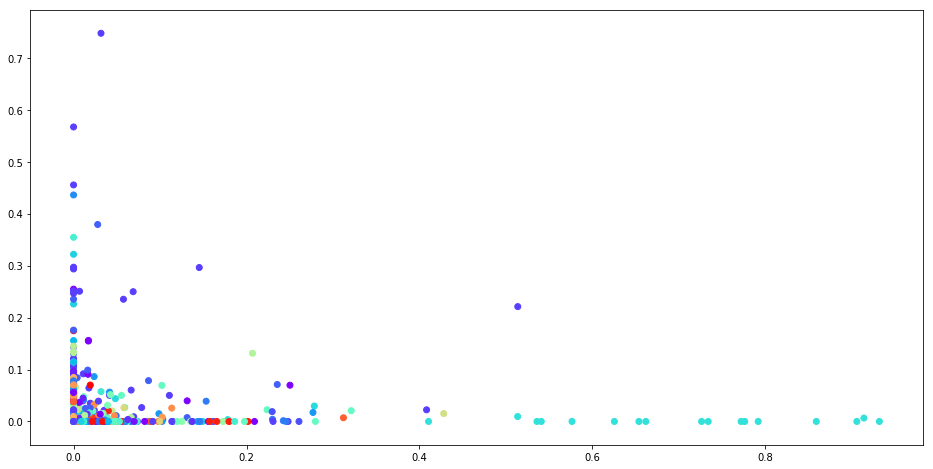

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_, cmap='rainbow') 

In [12]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer

In [13]:
pca = PCA(n_components=100)
values = Normalizer().fit_transform(X)
pca_result = pca.fit_transform(values)
pca_variance = np.sum(pca.explained_variance_ratio_)

f'Cumulative explained variation for 25 principal components: {pca_variance}'

'Cumulative explained variation for 25 principal components: 0.7612302657524597'

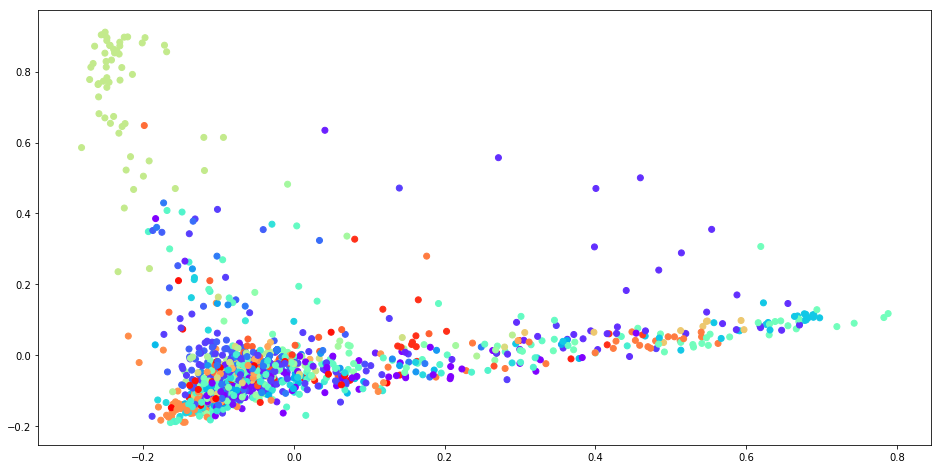

In [14]:
plt.figure(figsize=(16, 8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=cluster.labels_, cmap='rainbow')  

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, learning_rate=5, perplexity=100, n_iter=10**4)
tsne_results = tsne.fit_transform(pca_result)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1417 samples in 0.000s...
[t-SNE] Computed neighbors for 1417 samples in 0.391s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1417
[t-SNE] Computed conditional probabilities for sample 1417 / 1417
[t-SNE] Mean sigma: 0.363335
[t-SNE] KL divergence after 50 iterations with early exaggeration: 58.262238
[t-SNE] Error after 5000 iterations: 1.050538


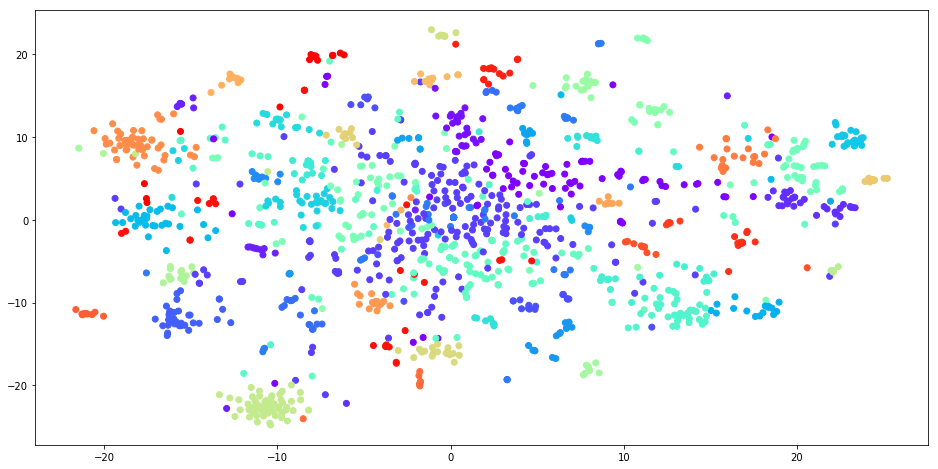

In [16]:
plt.figure(figsize=(16, 8))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cluster.labels_, cmap='rainbow')  

In [23]:
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3

bpl.output_notebook()

Loading BokehJS ...

In [94]:
colors = list(map(lambda c: (c[0], c[1], c[2]),
                  (plt.get_cmap("rainbow")(np.linspace(0.0, 1.0, 100))[np.newaxis, :, :3][0] * 255).astype(int)))

In [96]:
# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
# ]

TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

color_map = bmo.CategoricalColorMapper(factors=list(map(str, np.unique(cluster.labels_))), palette=colors[:50])

p = bpl.figure(tools=TOOLS)
p.scatter(tsne_results[:,0], tsne_results[:,1],
          fill_color=["#%02x%02x%02x" % colors[x] for x in cluster.labels_], fill_alpha=0.8,
          line_color=None)

bpl.show(p)